In [123]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
import calendar
import torch
from models import MLP, ConvNet, LSTM
from train_test import train, test, output_to_accu, output_to_loss

In [267]:
indice_weight = pd.read_excel('data/Insurances.xlsx', sheet_name='raw_weight', skiprows=[1], index_col=0, parse_dates=True)
indice_weight.drop(columns=indice_weight.columns[0], inplace=True)
indice_weight.index.name = 'Date'
indice_weight = indice_weight.T
indice_weight.index = pd.to_datetime(indice_weight.index, format='%m/%d/%Y')
indice_weight = indice_weight / 100
indice_weight.replace(0, np.nan, inplace=True)
indice_weight.head()

Date,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2005-12-30,0.0492,0.0022,0.0144,0.0053,0.0232,0.0784,0.3588,0.0015,0.4670,NaN
2006-01-31,0.0520,0.0024,0.0151,0.0055,0.0225,0.0771,0.3555,0.0015,0.4683,NaN
2006-02-28,0.0502,0.0023,0.0144,0.0053,0.0218,0.0897,0.3282,0.0014,0.4868,NaN
2006-03-31,0.0557,0.0027,0.0143,0.0058,0.0243,0.0999,0.3179,0.0015,0.4778,NaN
2006-04-28,0.0569,0.0027,0.0163,0.0057,0.0237,0.1048,0.3165,0.0016,0.4718,NaN


In [322]:
tickers_name = ['BALOISE', 'GENERALI', 'HELVETIA', 'SCHWEIZERISCHE', 'SCOR', 'SWISS LIFE', 'SWISS REINSURANCE', 'VAUDOISE ASSURANCE', 'ZURICH INSURANCE', 'SWISS RE']
indice_weight.columns = tickers_name
indice_weight.head()

,BALOISE,GENERALI,HELVETIA,SCHWEIZERISCHE,SCOR,SWISS LIFE,SWISS REINSURANCE,VAUDOISE ASSURANCE,ZURICH INSURANCE,SWISS RE
2005-12-30,0.0492,0.0022,0.0144,0.0053,0.0232,0.0784,0.3588,0.0015,0.4670,NaN
2006-01-31,0.0520,0.0024,0.0151,0.0055,0.0225,0.0771,0.3555,0.0015,0.4683,NaN
2006-02-28,0.0502,0.0023,0.0144,0.0053,0.0218,0.0897,0.3282,0.0014,0.4868,NaN
2006-03-31,0.0557,0.0027,0.0143,0.0058,0.0243,0.0999,0.3179,0.0015,0.4778,NaN
2006-04-28,0.0569,0.0027,0.0163,0.0057,0.0237,0.1048,0.3165,0.0016,0.4718,NaN


In [281]:
clean_tickers(daily_returns)
daily_returns

,BALN,GENN,HELN,NATN,CHRN,SLHN,RUKN,VAHN,ZURN,SREN
2006-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-01-06,-0.011134,0.026250,0.003563,0.000000,-0.016700,0.000826,-0.011208,0.007198,-0.014456,-0.011109
2006-01-09,-0.007677,0.005694,-0.001744,0.000000,0.003397,0.001651,0.009790,0.007038,-0.002590,0.009725
2006-01-10,0.009799,0.019772,-0.012480,-0.003094,-0.020311,0.004115,0.000510,0.021183,-0.011242,0.000498
...,...,...,...,...,...,...,...,...,...,...
2021-11-16,0.002736,0.000000,-0.000925,0.000000,0.000000,-0.002707,0.000000,0.000000,0.000995,-0.004261
2021-11-17,-0.004093,0.000000,-0.002778,0.000000,0.000000,0.005041,0.000000,0.010188,0.000000,0.000225
2021-11-18,-0.005479,0.000000,-0.006500,0.000000,0.000000,-0.001543,0.000000,-0.006056,0.000249,-0.000676
2021-11-19,-0.006887,0.000000,-0.010280,0.000000,0.000000,-0.005410,0.000000,-0.008130,-0.011180,-0.004507


In [223]:
prices = pd.read_excel('data/Insurances.xlsx', sheet_name='performance', skiprows=[0,1,2,4,5,6], index_col=0)
daily_returns = prices.pct_change().shift(1).fillna(0)
daily_returns.tail()

,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2021-11-16,0.002736,0.0,-0.000925,0.0,0.0,-0.002707,0.0,0.000000,0.000995,-0.004261
2021-11-17,-0.004093,0.0,-0.002778,0.0,0.0,0.005041,0.0,0.010188,0.000000,0.000225
2021-11-18,-0.005479,0.0,-0.006500,0.0,0.0,-0.001543,0.0,-0.006056,0.000249,-0.000676
2021-11-19,-0.006887,0.0,-0.010280,0.0,0.0,-0.005410,0.0,-0.008130,-0.011180,-0.004507
2021-11-22,-0.010402,0.0,-0.005666,0.0,0.0,-0.015540,0.0,0.010251,-0.013819,-0.009733


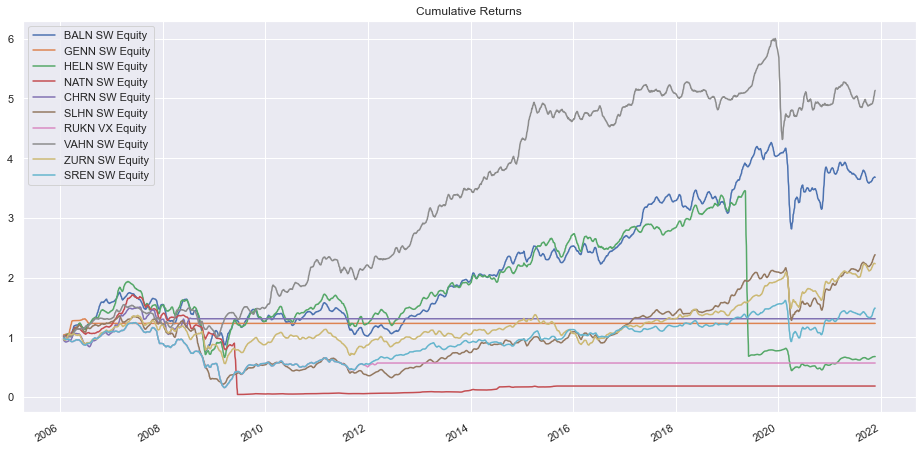

In [224]:
fig, ax = plt.subplots(figsize=(16,8))

(daily_returns + 1).cumprod().rolling(15).mean().plot(ax=ax)
plt.title('Cumulative Returns')
plt.show()

In [225]:
mmonthly_returns = daily_returns.shift(1).resample('M').agg(lambda x: (x + 1).prod() - 1)
max_ret = np.zeros_like(mmonthly_returns.values)
max_ret[np.arange(len(max_ret)), mmonthly_returns.values.argmax(1)] = 1
best_pred = pd.DataFrame(max_ret, columns=mmonthly_returns.columns, index=mmonthly_returns.index).astype(int).shift(-1)
best_pred.head()

,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2006-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2006-02-28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2006-04-30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


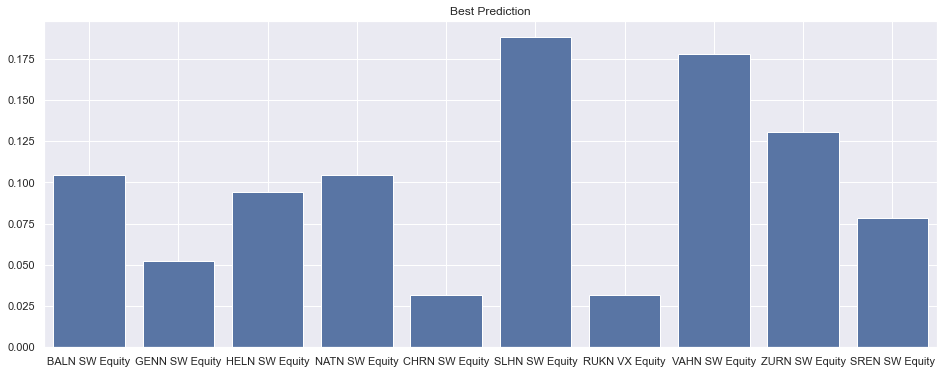

In [226]:
df_results = pd.DataFrame()
df_results = pd.concat([df_results, (best_pred.sum(axis=0) / len(best_pred)).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(ax=ax, data=df_results, x='index', y='frequence', hue='strategie', zorder=2)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.grid(b=True)
plt.title('Best Prediction')
plt.show()

In [314]:
all_ratios = pd.read_excel('data/ratio_data.xlsx', sheet_name=None, skiprows=[0,1,2,4,5], parse_dates=True, index_col=0)

df_X = pd.concat(all_ratios, axis=1)
df_X = df_X.swaplevel(0, 1, 1).sort_index(axis=1).fillna(method='ffill').shift(1).fillna(0)
clean_tickers(df_X, ratio=True)
new_cols = df_X.columns.reindex(indice_weight.columns, level=0)
df_X = df_X.reindex(columns=new_cols[0])
df_X.head()

BALN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28                 0.0  0.0  0.0             0.0      0.0  16.617   
2006-03-31                 0.0  0.0  0.0             0.0      0.0  15.884   
2006-04-28                 0.0  0.0  0.0             0.0      0.0  31.309   
2006-05-31                 0.0  0.0  0.0             0.0      0.0  26.176   

                          GENN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28                 0.0  0.0  0.0             0.0      0.0  26.095   
2006-03-31                 0.0  0.0  0.0             0.0      0.0  27.792   
2006-04-28                 0.0  0.0  0.0             0.0      0.0  36.368   
2006-05-31                 0.0  0.0  0.0             0.0      0.0   3.429   

                          HELN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28                 0.0  0.0  0.0             0.0      0.0  25.457   
2006-03-31                 0.0  0.0  0.0             0.0      0.0  16.703   
2006-04-28                 0.0  0.0  0.0             0.0      0.0  21.829   
2006-05-31                 0.0  0.0  0.0             0.0      0.0  37.849   

                          NATN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28                 0.0  0.0  0.0             0.0      0.0  10.934   
2006-03-31                 0.0  0.0  0.0             0.0      0.0  12.738   
2006-04-28                 0.0  0.0  0.0             0.0      0.0  19.855   
2006-05-31                 0.0  0.0  0.0             0.0      0.0  30.844   

                          CHRN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0   0.0000   0.000   
2006-02-28                 0.0  0.0  0.0             0.0   0.0000  27.432   
2006-03-31                 0.0  0.0  0.0             0.0   0.0000  19.748   
2006-04-28                 0.0  0.0  0.0             0.0  -0.4954  32.073   
2006-05-31                 0.0  0.0  0.0             0.0  -0.4954  22.954   

                          SLHN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28                 0.0  0.0  0.0             0.0      0.0  18.692   
2006-03-31                 0.0  0.0  0.0             0.0      0.0  16.730   
2006-04-28                 0.0  0.0  0.0             0.0      0.0  28.320   
2006-05-31                 0.0  0.0  0.0             0.0      0.0  25.178   

                          RUKN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28                 0.0  0.0  0.0             0.0      0.0  14.915   
2006-03-31                 0.0  0.0  0.0             0.0      0.0  14.401   
2006-04-28                 0.0  0.0  0.0             0.0      0.0  16.526   
2006-05-31                 0.0  0.0  0.0             0.0      0.0  15.024   

                          VAHN                                             \
           Cfgrwth_to_INCgrwth comb cost incre_oper_marg roc_wacc   vol30   
2006-01-31                 0.0  0.0  0.0             0.0      0.0   0.000   
2006-02-28     

In [265]:
def strategie(df_input_all, best_pred, model_name='MLP', nb_epochs=50, nb_epochs_first=200, input_period=4, training_window=5, batch_size=1, verbose=0, threshold=0.4, eta=1e-3):

    first_end_date = '2011-01-31'

    prob_output = []
    pred_output = []

    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M').index

    for i, end_date in enumerate(tqdm(all_end_dates)):

        start_date = end_date - relativedelta(years=training_window)

        start_date_input = (start_date - relativedelta(months=input_period)) 
        year, month = start_date_input.year, start_date_input.month
        start_date_input = start_date_input.replace(day=calendar.monthrange(year, month)[1])

        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date]

        X = []
        for idx in df_output.index:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)

        X = np.array(X)
        y = df_output.values

        # Find the first prediction date
        if i == 0:
            first_start_date_test = end_date - relativedelta(months=5)

        start_date_test = (end_date - relativedelta(months=5))
        # Make sur the first test date is the end of the month
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)     

        # Create train and test set
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]

        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        # Standardize data within each feature 
        train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
        train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)

        test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
        test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        # Allocate the tensors to the GPU, if there is one
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        y_train = y_train.to(device)
        y_test = y_test.to(device)

        # Initialize ML models only at first iteration
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if i == 0:
            if model_name == 'MLP':
                model = MLP(dim1, dim2, dim3)
            elif model_name == 'ConvNet':
                model = ConvNet(dim1, dim2, dim3)
            elif model_name == 'LSTM':
                model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
        model.to(device)

        # More epochs needed for the first iteration 
        if i == 0:
            nb_epochs_all = nb_epochs_first
        else:
            nb_epochs_all = nb_epochs
        # Train the model
        train(model, X_train, y_train, nb_epochs_all, X_test, y_test, i, eta=eta, batch_size=batch_size, verbose=verbose)

        # Get predictions
        prob = test(model, X_test, y_test, threshold=0.4)
        prob_output.append(prob)

    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

    return df_prob

In [266]:
# models_list = ['MLP', 'ConvNet', 'LSTM']
models_list = ['MLP', 'ConvNet']
#models_list = ['MLP']
#df_pred_dict = {}
df_prob_dict = {}

threshold = 0.5
batch_size = 5
verbose = 1
training_window = 4
nb_epochs_first = 500
nb_epochs = 300
eta = 5e-3
input_period = 4

for i, model_name in enumerate(models_list):
    df_prob_dict[model_name] = strategie(df_input_all=df_X, best_pred=best_pred, 
                                                                   model_name=model_name, nb_epochs=nb_epochs, 
                                                                   nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                                                   batch_size=batch_size, verbose=verbose, 
                                                                   training_window=training_window, threshold=threshold, eta=eta)
    
    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]
        
df_prob_dict['Ensemble'] /= len(models_list)

  0%|          | 0/22 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [256]:
n = 2
weight = 0.1

results = remove_tickers(indice_weight, df_prob_dict['MLP'])
df_signal = pd.DataFrame().reindex_like(results)
for index, row in results.iterrows():
    all_tickers = list(row.index)
    largest_tickers = list(row.nlargest(n).index)
    smallest_tickers = list(row.nsmallest(n).index)
    other_tickers = list(set(all_tickers).difference(largest_tickers + smallest_tickers))
    df_signal.at[index, largest_tickers] = 1
    df_signal.at[index, smallest_tickers] = - 1
    df_signal.at[index, other_tickers] = 0.
    #df_signal = df_signal * weight
df_signal = remove_tickers(indice_weight, df_signal) * weight
indice_weight = indice_weight.reindex(df_prob_dict[model_name].index, method='ffill')
portfolio = indice_weight + df_signal
daily_returns_backtest = daily_returns.loc[portfolio.index[0]:portfolio.index[-1]]
perf = (portfolio.reindex(daily_returns_backtest.index, method='ffill').mul(daily_returns_backtest).sum(axis=1) + 1).cumprod()

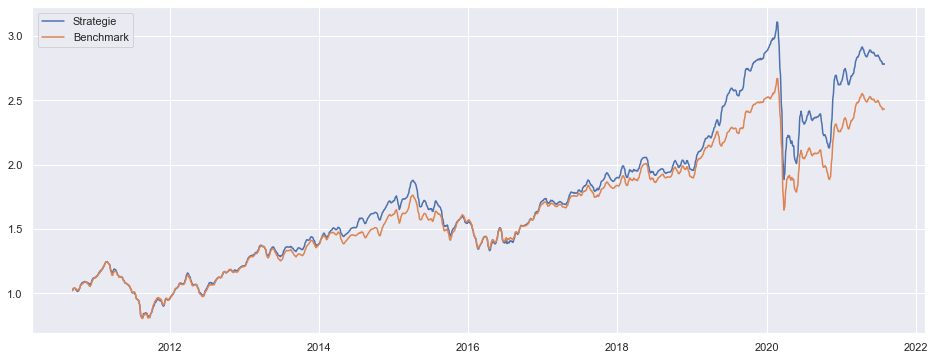

In [257]:
bench_perf = (indice_weight.reindex(daily_returns_backtest.index, method='ffill').mul(daily_returns_backtest).sum(axis=1) + 1).cumprod()
data_plot = pd.concat([perf, bench_perf], axis=1)
data_plot.columns = ['Strategie', 'Benchmark']

fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(data=data_plot.rolling(10).mean(), dashes=False)
plt.show()

  0%|          | 0/22 [00:00<?, ?it/s]

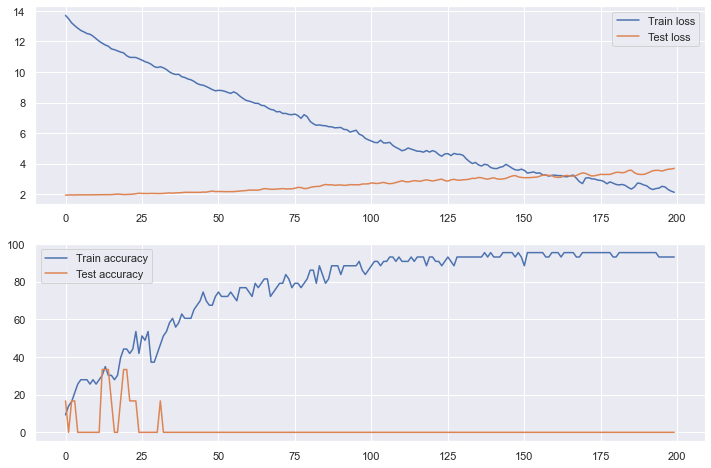

  5%|▍         | 1/22 [00:04<01:27,  4.17s/it]

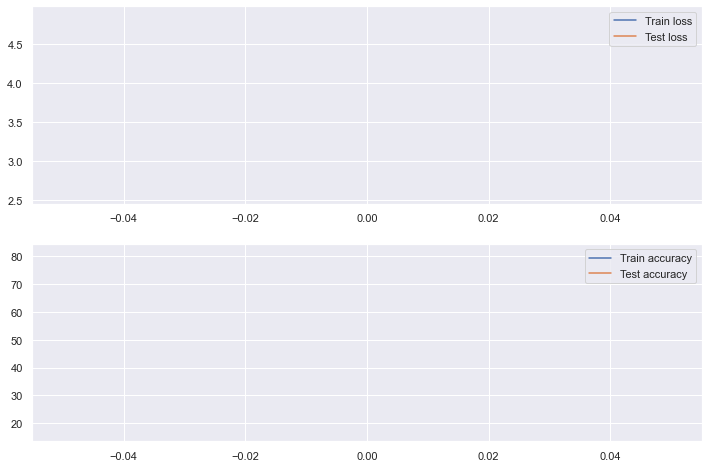

  9%|▉         | 2/22 [00:04<01:00,  3.03s/it]

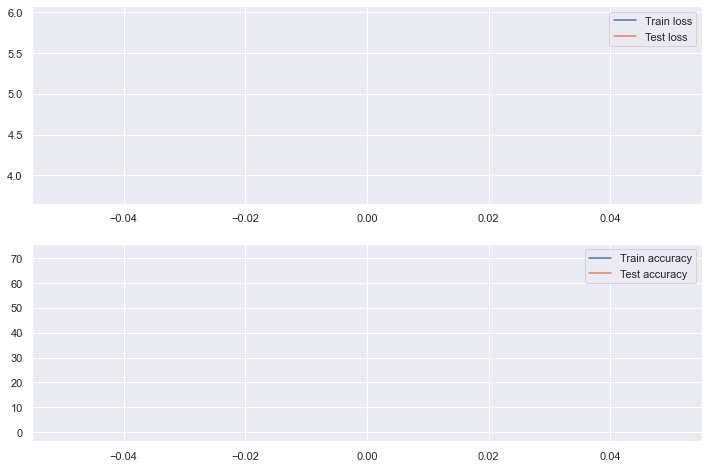

100%|██████████| 22/22 [00:05<00:00,  4.02it/s]


,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2010-08-31,0.000108,0.000155,0.656935,0.000724,0.000002,0.236559,0.023076,0.071159,0.006781,0.004502
2010-09-30,0.000930,0.003731,0.650445,0.014581,0.000225,0.215564,0.046789,0.035629,0.023142,0.008964
2010-10-31,0.007650,0.039986,0.257945,0.061318,0.069930,0.002688,0.051033,0.027693,0.480335,0.001422
2010-11-30,0.007965,0.036556,0.116827,0.158645,0.157488,0.001571,0.022961,0.025312,0.471860,0.000815
2010-12-31,0.002455,0.016107,0.728864,0.035670,0.004711,0.017192,0.093300,0.016170,0.085261,0.000272
2011-01-31,0.051238,0.046945,0.657451,0.012785,0.022978,0.003758,0.017734,0.054488,0.129746,0.002877
2011-02-28,0.085701,0.063934,0.134865,0.044599,0.133488,0.001220,0.003704,0.080924,0.443400,0.008166
2011-03-31,0.004954,0.006508,0.777764,0.004569,0.000438,0.036809,0.011078,0.076085,0.072034,0.009760
2011-04-30,0.001091,0.002526,0.897646,0.003570,0.000407,0.011724,0.037835,0.022425,0.022368,0.000408
2011-05-31,0.003586,0.008596,0.756702,0.018036,0.002483,0.018739,0.108249,0.033546,0.049498,0.000565


In [325]:
df_input_all = df_X
input_period = 6
training_window = 4
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())
model_name = 'MLP'
nb_epochs_first = 200
nb_epochs = 1
eta = 1e-3
batch_size = 5
verbose = 1

first_end_date = '2011-01-31'

prob_output = []
pred_output = []

all_end_dates = best_pred.loc[first_end_date:].asfreq('6M').index

for i, end_date in enumerate(tqdm(all_end_dates)):

    start_date = end_date - relativedelta(years=training_window)

    start_date_input = (start_date - relativedelta(months=input_period)) 
    year, month = start_date_input.year, start_date_input.month
    start_date_input = start_date_input.replace(day=calendar.monthrange(year, month)[1])
    
    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    for idx in df_output.index:
        df_input_period = df_input.loc[:idx].iloc[-input_period:]
        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)

    X = np.array(X)
    y = df_output.values

    # Find the first prediction date
    if i == 0:
        first_start_date_test = end_date - relativedelta(months=5)

    start_date_test = (end_date - relativedelta(months=5))
    # Make sur the first test date is the end of the month
    year_test, month_test = start_date_test.year, start_date_test.month
    start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
    split_index = df_output.index.get_loc(start_date_test)     

    # Create train and test set
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Transform Numpy arrays to Torch tensors
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    # Standardize data within each feature 
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)

    # Allocate the tensors to the GPU, if there is one
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # Initialize ML models only at first iteration
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers)
    model.to(device)

    # More epochs needed for the first iteration 
    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs
    # Train the model
    train(model, X_train, y_train, nb_epochs_all, X_test, y_test, i, eta=eta, batch_size=batch_size, verbose=verbose)

    # Get predictions
    prob, _ = test(model, X_test, y_test, threshold=0.4)

    prob_output.append(prob)

prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

df_prob.head()

In [326]:
df_prob

,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2010-08-31,0.000108,0.000155,0.656935,0.000724,0.000002,0.236559,0.023076,0.071159,0.006781,0.004502
2010-09-30,0.000930,0.003731,0.650445,0.014581,0.000225,0.215564,0.046789,0.035629,0.023142,0.008964
2010-10-31,0.007650,0.039986,0.257945,0.061318,0.069930,0.002688,0.051033,0.027693,0.480335,0.001422
2010-11-30,0.007965,0.036556,0.116827,0.158645,0.157488,0.001571,0.022961,0.025312,0.471860,0.000815
2010-12-31,0.002455,0.016107,0.728864,0.035670,0.004711,0.017192,0.093300,0.016170,0.085261,0.000272
2011-01-31,0.051238,0.046945,0.657451,0.012785,0.022978,0.003758,0.017734,0.054488,0.129746,0.002877
2011-02-28,0.085701,0.063934,0.134865,0.044599,0.133488,0.001220,0.003704,0.080924,0.443400,0.008166
2011-03-31,0.004954,0.006508,0.777764,0.004569,0.000438,0.036809,0.011078,0.076085,0.072034,0.009760
2011-04-30,0.001091,0.002526,0.897646,0.003570,0.000407,0.011724,0.037835,0.022425,0.022368,0.000408
2011-05-31,0.003586,0.008596,0.756702,0.018036,0.002483,0.018739,0.108249,0.033546,0.049498,0.000565


In [328]:
df_signal = pd.DataFrame().reindex_like(results)
for index, row in results.iterrows():
    all_tickers = list(row.index)
    largest_tickers = list(row.nlargest(n).index)
    smallest_tickers = list(row.nsmallest(n).index)
    other_tickers = list(set(all_tickers).difference(largest_tickers + smallest_tickers))
    df_signal.at[index, largest_tickers] = 1
    df_signal.at[index, smallest_tickers] = -1
    df_signal.at[index, other_tickers] = 0.
df_signal

,BALN SW Equity,GENN SW Equity,HELN SW Equity,NATN SW Equity,CHRN SW Equity,SLHN SW Equity,RUKN VX Equity,VAHN SW Equity,ZURN SW Equity,SREN SW Equity
2010-08-31,1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,0.0
2010-09-30,0.0,0.0,-1.0,-1.0,0.0,1.0,1.0,0.0,0.0,0.0
2010-10-31,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,1.0,1.0,0.0
2010-11-30,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0,0.0
2010-12-31,-1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0
2011-01-31,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,1.0,0.0
2011-02-28,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0
2011-03-31,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2011-04-30,-1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0
2011-05-31,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0


In [333]:
(df_signal.diff() != 0).astype(int).abs().sum(axis=1) * 0.0012

2010-08-31    0.0120
2010-09-30    0.0060
2010-10-31    0.0060
2010-11-30    0.0048
2010-12-31    0.0048
2011-01-31    0.0024
2011-02-28    0.0060
2011-03-31    0.0036
2011-04-30    0.0036
2011-05-31    0.0024
2011-06-30    0.0084
2011-07-31    0.0072
2011-08-31    0.0072
2011-09-30    0.0060
2011-10-31    0.0000
2011-11-30    0.0000
2011-12-31    0.0060
2012-01-31    0.0024
2012-02-29    0.0060
2012-03-31    0.0048
2012-04-30    0.0000
2012-05-31    0.0024
2012-06-30    0.0000
2012-07-31    0.0072
2012-08-31    0.0072
2012-09-30    0.0024
2012-10-31    0.0060
2012-11-30    0.0072
2012-12-31    0.0024
2013-01-31    0.0000
2013-02-28    0.0000
2013-03-31    0.0000
2013-04-30    0.0000
2013-05-31    0.0000
2013-06-30    0.0000
2013-07-31    0.0000
2013-08-31    0.0084
2013-09-30    0.0024
2013-10-31    0.0000
2013-11-30    0.0000
2013-12-31    0.0000
2014-01-31    0.0024
2014-02-28    0.0024
2014-03-31    0.0000
2014-04-30    0.0048
2014-05-31    0.0024
2014-06-30    0.0048
2014-07-31   